CNN Modelling

In [15]:
#Importing the required libraries
import pandas as pd
import numpy as np
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical

import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
#Loading the dataset
Premodelled_df= pd.read_csv('/content/Premodelled_data.csv')
Premodelled_df.head()

,id,original_text,text,listed_emotions,emotion_count,labels,encoded_labels
0,eew5j0j,That game hurt.,game hurt,sadness,1,negative,1
1,ed2mah1,"You do right, if you don't care then fuck 'em!",right dont care fuck em,neutral,1,neutral,2
2,eeibobj,Man I love reddit.,man love reddit,love,1,positive,3
3,eda6yn6,"[NAME] was nowhere near them, he was by the Fa...",name nowhere near falcon,neutral,1,neutral,2
4,eespn2i,Right? Considering it’s such an important docu...,right considering ’ important document know da...,gratitude,1,positive,3


In [17]:
#Classifying the text and encoded_labels
text_label = Premodelled_df[['text','encoded_labels']]
text_label.head()

,text,encoded_labels
0,game hurt,1
1,right dont care fuck em,2
2,man love reddit,3
3,name nowhere near falcon,2
4,right considering ’ important document know da...,3


In [18]:
text_label.encoded_labels.unique()

array([1, 2, 3, 0])

In [19]:
#Converting the 'text' column to strings
text_label['text'] = text_label['text'].astype(str)

#Performing lemmatization on the cleaned text column
# Create an instance of WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Function to apply lemmatization to a list of words
def apply_lemmatization(word_list):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in word_list] #lemmatize each word
    lemmatized_text = ' '.join(['[' + lemmatizer.lemmatize(word) + ']' for word in word_list]) #Joining lemmatized words
    return lemmatized_text

# Create a new column 'lemmatized_column' with the lemmatized text
text_label['lemmatized_column'] = text_label['text'].apply(lambda text: apply_lemmatization(word_tokenize(text)))

# Print the updated DataFrame
print(text_label)

                                                     text  encoded_labels  \
0                                               game hurt               1   
1                                 right dont care fuck em               2   
2                                         man love reddit               3   
3                                name nowhere near falcon               2   
4       right considering ’ important document know da...               3   
...                                                   ...             ...   
207809  well im glad youre awful way act make think he...               3   
207810                                 everyone like name               3   
207811    well ’ imported gazillion country ’ get serious               3   
207812                                       look amazing               3   
207813  fda plenty criticize like usually criticized h...               1   

                                        lemmatized_column  
0              

In [10]:
#Creating a new dataframe with the lemmatized column and encoded labels
text_label_1  = text_label[['lemmatized_column','encoded_labels']]
text_label_1.head()

,lemmatized_column,encoded_labels
0,[game] [hurt],1
1,[right] [dont] [care] [fuck] [em],2
2,[man] [love] [reddit],3
3,[name] [nowhere] [near] [falcon],2
4,[right] [considering] [’] [important] [documen...,3


In [20]:
#Performing tokenisation and train test splits on the lemmatized_column and encoded_labels

# Batch Processing Configuration
batch_size = 1000

# Tokenization and Data Preparation
# Tokenization
tokenizer = Tokenizer(num_words=5000)  # Limit vocabulary size to the most frequent 5000 words
tokenizer.fit_on_texts(text_label_1['lemmatized_column'])  # Fit the tokenizer on lemmatized text
word_index = tokenizer.word_index  # Get the word index

# Convert text to sequences of integers in batches
sequences = []
for i in range(0, len(text_label_1), batch_size):
    batch_texts = text_label['lemmatized_column'][i:i + batch_size].tolist()
    batch_sequences = tokenizer.texts_to_sequences(batch_texts)
    sequences.extend(batch_sequences)

# Padding sequences to a fixed length
max_sequence_length = max(len(sequence) for sequence in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Convert encoded_labels to numpy array
labels = np.array(text_label_1['encoded_labels'])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Print the shapes of train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (166251, 21)
X_test shape: (41563, 21)
y_train shape: (166251,)
y_test shape: (41563,)


In [19]:

vocab_size = len(word_index) + 1

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(4, activation='softmax'))  # Four units for four classes, using softmax activation

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convert labels to one-hot encoded format
one_hot_labels = to_categorical(labels, num_classes=4)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, one_hot_labels, test_size=0.2, random_state=42)

# Print the shapes of train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model
epochs = 10
batch_size = 32

#Fitting the model
model.fit(X_train, one_hot_labels, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])

# Evaluation on test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


X_train shape: (166251, 21)
X_test shape: (41563, 21)
y_train shape: (166251, 4)
y_test shape: (41563, 4)
Epoch 1/10
4676/4676 [==============================] - 220s 47ms/step - loss: 1.2232 - accuracy: 0.4191 - val_loss: 1.2233 - val_accuracy: 0.4196
Epoch 2/10
4676/4676 [==============================] - 219s 47ms/step - loss: 1.2094 - accuracy: 0.4193 - val_loss: 1.2425 - val_accuracy: 0.3805
Epoch 3/10
4676/4676 [==============================] - 229s 49ms/step - loss: 1.1656 - accuracy: 0.4433 - val_loss: 1.2746 - val_accuracy: 0.3959
Epoch 4/10
1299/1299 [==============================] - 4s 3ms/step - loss: 1.2233 - accuracy: 0.4179
Test Loss: 1.2232732772827148
Test Accuracy: 0.4179438352584839


The results obtained are as shown



*  X_train shape: (166251, 21)
*  X_test shape: (41563, 21)
*  y_train shape: (166251, 4)
*  y_test shape: (41563, 4)

*   Epoch 1/10 val_loss: 1.2233 - val_accuracy: 0.4196
*   Epoch 2/10 val_loss: 1.2425 - val_accuracy: 0.3805
*   Epoch 3/10 val_loss: 1.2746 - val_accuracy: 0.3959
*   Epoch 4/10 val_loss: 1.3088 - val_accuracy: 0.3705


Test Loss: 1.2232732772827148
Test Accuracy: 0.4179438352584839

In [ ]:
#Padding using a word index length and adding 1 for the padding sequence
vocab_size = len(word_index) + 1
embedding_dim = 100

# Convert labels to one-hot encoded format
one_hot_labels = to_categorical(labels, num_classes=4)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, one_hot_labels, test_size=0.2, random_state=42)

# Define a range of epochs and batch sizes to iterate over
epochs_range = range(1, 11)
batch_sizes = [32,64,128]

#Creating a nested loop to iterate through all the epochs range and batch sizes
for batch_size in batch_sizes:
    for epochs in epochs_range:
        print(f"Training model with batch size = {batch_size}, epochs = {epochs}")

        model = Sequential()
        model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
        model.add(Conv1D(128, 5, activation='relu'))
        model.add(GlobalMaxPooling1D())
        model.add(Dense(4, activation='softmax'))  # Four units for four classes, using softmax activation

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Early Stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # Fitting the model
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])

        # Evaluation on test set
        loss, accuracy = model.evaluate(X_test, y_test)
        print(f"Test Loss (epochs={epochs}, batch_size={batch_size}):", loss)
        print(f"Test Accuracy (epochs={epochs}, batch_size={batch_size}):", accuracy)


Training model with batch size = 32, epochs = 1
1299/1299 [==============================] - 5s 4ms/step - loss: 1.0069 - accuracy: 0.5694
Test Loss (epochs=1, batch_size=32): 1.006858229637146
Test Accuracy (epochs=1, batch_size=32): 0.5694487690925598
Training model with batch size = 32, epochs = 2
Epoch 1/2
4676/4676 [==============================] - 238s 51ms/step - loss: 1.0283 - accuracy: 0.5513 - val_loss: 1.0096 - val_accuracy: 0.5644
Epoch 2/2
1299/1299 [==============================] - 6s 4ms/step - loss: 0.9935 - accuracy: 0.5796
Test Loss (epochs=2, batch_size=32): 0.9934648275375366
Test Accuracy (epochs=2, batch_size=32): 0.5795539021492004
Training model with batch size = 32, epochs = 3
Epoch 1/3
4676/4676 [==============================] - 318s 49ms/step - loss: 1.0282 - accuracy: 0.5519 - val_loss: 0.9984 - val_accuracy: 0.5703
Epoch 2/3
4676/4676 [==============================] - 232s 50ms/step - loss: 0.9502 - accuracy: 0.5976 - val_loss: 0.9994 - val_accuracy: 0.

In [ ]:
#The ouptuts for the different iterations are shown below

Training model with batch size = 16, epochs = 1

Test Loss (epochs=1, batch_size=16): 0.999070405960083
Test Accuracy (epochs=1, batch_size=16): 0.570122480392456
Training model with batch size = 16, epochs = 2

---


Epoch 1/2 - val_loss: 1.0032 - val_accuracy: 0.5669

---


Epoch 2/2 - val_loss: 1.0046 - val_accuracy: 0.5742

---


Epoch 3/3 - val_loss: 1.0214 - val_accuracy: 0.5701

---


Epoch 4/4 - val_loss: 1.0480 - val_accuracy: 0.5688

---

Epoch 5/5 - val_loss: 1.0551 - val_accuracy: 0.5716

---

Epoch 6/6 - val_loss: 1.0570 - val_accuracy: 0.5740

---

Epoch 7/7- val_loss: 1.0725 - val_accuracy: 0.5747

---

Epoch 8/8 - val_loss: 1.0968 - val_accuracy: 0.5710

---

Epoch 9/9- val_loss: 1.1088 - val_accuracy: 0.5646

---

Epoch 10/10 - val_loss: 1.1041 - val_accuracy: 0.5679

---

Epoch 11/11 - val_loss: 1.1084 - val_accuracy: 0.5703

---




Training model with batch size = 64, epochs = 1 - val_loss: 0.9967 - val_accuracy: 0.5742

---
Epoch 1/2 - val_loss: 1.0030 - val_accuracy: 0.5717
---
Epoch 2/2- val_loss: 1.0048 - val_accuracy: 0.5736
---
Epoch 3/3- val_loss: 1.0159 - val_accuracy: 0.5713
---
Epoch 4/4 - val_loss: 1.0430 - val_accuracy: 0.5747
---
Epoch 5/5 - val_loss: 1.0548 - val_accuracy: 0.5715
---
Epoch 6/6 - val_loss: 1.0853 - val_accuracy: 0.5704
---
Epoch 7/7 - val_loss: 1.1043 - val_accuracy: 0.5672
---
Epoch 8/8 - val_loss: 1.1107 - val_accuracy: 0.5688
---
Epoch 9/9 - val_loss: 1.1271 - val_accuracy: 0.5611
---
Epoch 10/10 - val_loss: 1.1398 - val_accuracy: 0.5651



Training model with batch size = 128, epochs = 1 - val_loss: 0.9952 - val_accuracy: 0.5721
---
Epoch 1/2 - val_loss: 0.9957 - val_accuracy: 0.5721
---
Epoch 2/2 - val_loss: 0.9969 - val_accuracy: 0.5776
---
Epoch 3/3 - val_loss: 1.0125 - val_accuracy: 0.5777
---
Epoch 4/4 - val_loss: 1.0340 - val_accuracy: 0.5735
---
Epoch 5/5 - val_loss: 1.0591 - val_accuracy: 0.5675
---
Epoch 6/6 - val_loss: 1.0886 - val_accuracy: 0.5697
---
Epoch 7/7 - val_loss: 1.1018 - val_accuracy: 0.5704
---
Epoch 8/8 - val_loss: 1.1190 - val_accuracy: 0.5684
---
Epoch 9/9 - val_loss: 1.1361 - val_accuracy: 0.5678
---
Epoch 10/10 - val_loss: 1.1496 - val_accuracy: 0.5654
---
Test Loss (epochs=10, batch_size=128): 1.1456750631332397
Test Accuracy (epochs=10, batch_size=128): 0.5665375590324402

Performing Hyper Parameter tuning for the above model using: -


*   5 random iterations of hyperparameter combinations
*   3 fold cross validation





In [22]:
# Define the CNN model function
def create_cnn_model(num_filters=128, dense_size=128):
    model = Sequential()
    model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length))
    model.add(Conv1D(num_filters, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dense(4, activation='softmax'))  # Four units for four classes, using softmax activation

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create KerasClassifier for RandomizedSearchCV
model = KerasClassifier(build_fn=create_cnn_model, verbose=0)

# Define hyperparameter grid for Random Search
param_grid = {
    'num_filters': [64, 128, 256],
    'dense_size': [64, 128, 256]
}

# Perform Random Search with 3-fold cross-validation
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=5, cv=3, verbose=2)
random_search_result = random_search.fit(padded_sequences, one_hot_labels)

# Print the best hyperparameters and their corresponding accuracy
print("Best Hyperparameters: ", random_search_result.best_params_)
print("Best Accuracy: ", random_search_result.best_score_)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ....................dense_size=128, num_filters=128; total time= 4.6min
[CV] END ....................dense_size=128, num_filters=128; total time= 4.6min
[CV] END ....................dense_size=128, num_filters=128; total time= 4.5min
[CV] END .....................dense_size=256, num_filters=64; total time= 3.3min
[CV] END .....................dense_size=256, num_filters=64; total time= 3.2min
[CV] END .....................dense_size=256, num_filters=64; total time= 3.6min
[CV] END ....................dense_size=256, num_filters=256; total time= 4.6min
[CV] END ....................dense_size=256, num_filters=256; total time= 4.6min
[CV] END ....................dense_size=256, num_filters=256; total time= 4.6min
[CV] END .....................dense_size=64, num_filters=256; total time= 4.4min
[CV] END .....................dense_size=64, num_filters=256; total time= 4.7min
[CV] END .....................dense_size=64, num_

The following are the best hyperparameters obtained
Fitting 3 folds for each of 5 candidates, totalling 15 fits

---
[CV] END ....................dense_size=128, num_filters=128; total time= 4.6min
---
[CV] END ....................dense_size=128, num_filters=128; total time= 4.6min
---
[CV] END ....................dense_size=128, num_filters=128; total time= 4.5min
---
[CV] END .....................dense_size=256, num_filters=64; total time= 3.3min
---
[CV] END .....................dense_size=256, num_filters=64; total time= 3.2min
---
[CV] END .....................dense_size=256, num_filters=64; total time= 3.6min
---
[CV] END ....................dense_size=256, num_filters=256; total time= 4.6min
---
[CV] END ....................dense_size=256, num_filters=256; total time= 4.6min
---
[CV] END ....................dense_size=256, num_filters=256; total time= 4.6min
---
[CV] END .....................dense_size=64, num_filters=256; total time= 4.4min
---
[CV] END .....................dense_size=64, num_filters=256; total time= 4.7min
---
[CV] END .....................dense_size=64, num_filters=256; total time= 4.6min
---
[CV] END ......................dense_size=64, num_filters=64; total time= 3.5min
---
[CV] END ......................dense_size=64, num_filters=64; total time= 3.6min
---
[CV] END ......................dense_size=64, num_filters=64; total time= 3.2min
---
Best Hyperparameters:  {'num_filters': 64, 'dense_size': 64}
Best Accuracy:  0.5702888170878092





In [26]:
#Including the best num_filters and dense_size of 64
from sklearn.metrics import confusion_matrix

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, one_hot_labels, test_size=0.2, random_state=42)

best_model = create_cnn_model(num_filters=64, dense_size=64)  # Use the best parameters

# Training the model on the training set
best_model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1, verbose=1)

# Making predictions on the test set
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert predicted probabilities to class labels

# Converting the one-hot encoded test labels back to integer labels
y_test_labels = np.argmax(y_test, axis=1)

# Creating the confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred)

print("Confusion Matrix:")
print(conf_matrix)



Epoch 1/10
1169/1169 [==============================] - 77s 65ms/step - loss: 1.0415 - accuracy: 0.5436 - val_loss: 1.0069 - val_accuracy: 0.5678
Epoch 2/10
1169/1169 [==============================] - 78s 66ms/step - loss: 0.9511 - accuracy: 0.5980 - val_loss: 0.9976 - val_accuracy: 0.5722
Epoch 3/10
1169/1169 [==============================] - 74s 63ms/step - loss: 0.8888 - accuracy: 0.6273 - val_loss: 1.0132 - val_accuracy: 0.5733
Epoch 4/10
1169/1169 [==============================] - 74s 63ms/step - loss: 0.8363 - accuracy: 0.6453 - val_loss: 1.0349 - val_accuracy: 0.5706
Epoch 5/10
1169/1169 [==============================] - 75s 64ms/step - loss: 0.7938 - accuracy: 0.6564 - val_loss: 1.0721 - val_accuracy: 0.5737
Epoch 6/10
1169/1169 [==============================] - 78s 66ms/step - loss: 0.7588 - accuracy: 0.6629 - val_loss: 1.0817 - val_accuracy: 0.5718
Epoch 7/10
1169/1169 [==============================] - 75s 64ms/step - loss: 0.7289 - accuracy: 0.6669 - val_loss: 1.1293 -

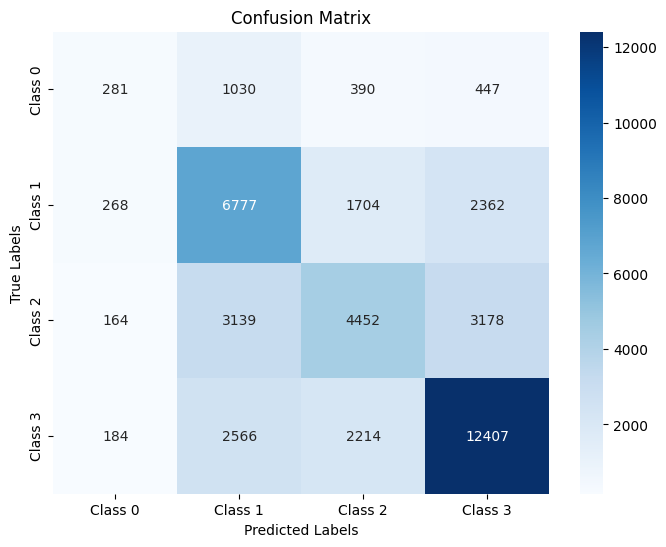

In [27]:
# Create the confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Here's the interpretation of the confusion matrix:
---
Class 0 (Ambigous): True Positives (TP) = 281, False Positives (FP) = 1030, False Negatives (FN) = 268 True Negatives(TN) = 447
---
Class 1 (Negative): TP = 6777, FP = 1704, FN = 268
---
Class 2 (Neutral): TP = 4452, FP = 3178, FN = 164
---
Class 3 (Positive): TP = 12407, FP = 2214, FN = 184
---

